<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Building a CNN**


Estimated time needed: **30** minutes


## A mission to automate monitoring of flowering

Climate warning is causing a lot of changes in the timing and duration of flowering seasons, making it hard for the flower planting company to monitor the growing of various species. To study the changes, the company's biologists are monitoring the plants in small permanently marked areas and performing manual collection and analysis of the plant phenology details.

You are now hired by the company as a Data Scientist to help automate the monitoring process. The first step of your mission is to create a flower type identification system, so that it could greatly reduce the time and cost of tracking the flowers on an indivifual level.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/flowershop.jpeg" width="80%"></center>


In this lab, we will tie together everything we've learned in previous CNN labs and apply our new found skills in a object recognition task.

This lab takes concepts learned in this Deep Learning and Reinforcement Learning course and applies them in the creation of a CNN model.

We will be implementing a model that classifies images employing multiple convolutional **filters** for multi-**channel**/RGB images, adding **padding** to images to preserve image sizes/capture edge data, determining the best **stride** to use with the convolutional filters, passing that data through **activation functions** such as ReLU and **pooling** layers, and **flattenning** our results to obtain classes using **categorical cross entropy**.


## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>     
    </li>
    <li>
        <a href="#Example: Classifying Flowers">Example: Classifying Flowers</a>
        <ol>
            <li><a href="#Importing data">Importing data</a></li>
            <li><a href="#Building a classifier">Building a classifier</a></li>
            <li><a href="#Prediction!">Prediction!</a></li>
        </ol>   
    </li>
</ol>


## Objectives

After completing this lab you will be able to:

*   Explain how a convolution works on images
*   Understand the purposes of different kernels that exist
*   Apply kernels to images and obtain a useful result


***


## Setup


For this lab, we will be using the following libraries:

*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`Pillow`](https://pillow.readthedocs.io/en/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for image processing functions.
*   [`OpenCV`](https://docs.opencv.org/4.x/index.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for other image processing functions.
*   [`tensorflow`](https://www.tensorflow.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and neural network related functions.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Anaconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy numpy==1.22.3 matplotlib==3.5.1 tensorflow==2.9.0 opencv-python==4.5.5.62

# Note: If your environment doesn't support "!mamba install", use "!pip install --user"

# RESTART YOUR KERNEL AFTERWARD AS WELL

In [2]:
!pip install skillsnetwork

### Importing Required Libraries

*We recommend you import all required libraries in one place (here):*


In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageOps

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, BatchNormalization

### Defining Helper Functions


This function helps visualize the feature maps of the layers in a classifier.


In [6]:
def plot_activations_multilayer(n_layers, img_per_row, classifier, activations):

    layer_names = []
    for layer in classifier.layers:
        layer_names.append(layer.name + 'layer') # append each layer name

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1] # (1, size, size, n_features)
        size = layer_activation.shape[1] # (1, size, size, n_features)

        # SAMPLE --> 8 images per row with 4 rows total 32 photos (32 feature maps) in whole image
        n_rows = n_features // img_per_row
        # SAMPLE --> shape: (4 * 150, 8 * 150) = (600, 1200)
        display_grid = np.zeros((n_rows * size, img_per_row * size))

        for col in range(n_rows):
            for row in range(img_per_row):
                channel_img = layer_activation[0, :, :, col * img_per_row + row]
                display_grid[col * size : (col + 1) * size,
                            row * size : (row + 1) * size] = channel_img
                scale = 2. / size  # adjust feature map (small -> large, large -> small)

        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Example: Classifying Flowers


We will use our flower images from the image convolution lab. However, this time, we want to use them to train a CNN model for classification. Hence, we will utilize a training and test set.
https://www.tensorflow.org/tutorials/load_data/images


### Importing data

Lets take a look at the flowers dataset from tensorflow, retrieved from here: [https://www.tensorflow.org/datasets/catalog/tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)


In [7]:
import skillsnetwork
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/flower_photos.tgz"
await skillsnetwork.prepare(url, overwrite=True)

  0%|          | 0/3677 [00:00<?, ?it/s]

Saved to '.'


In [8]:
dir = Path("flower_photos")

for folder in dir.glob("[!LICENSE]*"):
    print(f"This {folder.name} has {len(list(folder.glob("*.jpg")))} pictures.")

img_count = len(list(dir.glob("*/*.jpg")))
print(img_count, 'total images.')

This tulips has 799 pictures.
This roses has 641 pictures.
This dandelion has 898 pictures.
This sunflowers has 699 pictures.
This daisy has 633 pictures.
3670 total images.


Let's extract some images we can use for this lab. We will set them all to be square images of 300x300, and display them as well.


In [9]:
img_w, img_h = 150, 150
batch_size = 64
epochs = 10

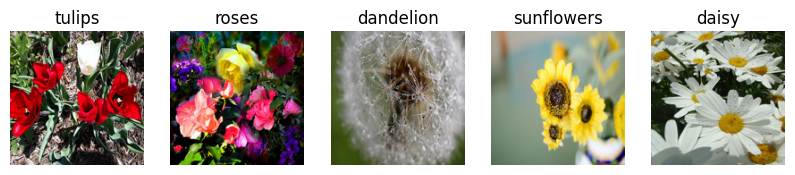

In [10]:
pics = list()
pics_arr = list()
p_class = list()

plt.figure(figsize=(10,5))
for i, folder in enumerate(dir.glob("[!LICENSE]*")):
    cat = list(dir.glob(folder.name + '/*'))
    pic = Image.open(str(cat[0])).resize((img_w, img_h))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1, 5, i+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)

Let's create a train set using the `ImageDataGenerator` and `flow_from_directory` functions from `keras.utils`.


In [11]:
train_gen = ImageDataGenerator(validation_split = 0.2,   # 20% validation
                               rescale = 1.0/255.0,      # normalize pixel values
                               width_shift_range = 0.2,  # 20% random image shift (left/right)
                               height_shift_range = 0.2, # 20% random image shift (up/down)
                               horizontal_flip = True)   # random flip image horizontal

# Reads images directly from a folder structure and generates them in batches.
train_set = train_gen.flow_from_directory(directory = dir,
                                          seed = 10, # set randomness
                                          class_mode = 'sparse', # label format (number)
                                          batch_size = batch_size, # images per batch
                                          shuffle = True, # shuffle images each batch
                                          target_size = (img_h, img_w), # resize all images
                                          subset = 'training') # training split

Found 2939 images belonging to 5 classes.


#### Exercise: Create validation set


In [12]:
val_gen = ImageDataGenerator(validation_split = 0.2,   # 20% validation
                             rescale = 1.0/255.0,      # normalize pixel values
                             width_shift_range = 0.2,  # 20% random image shift (left/right)
                             height_shift_range = 0.2, # 20% random image shift (up/down)
                             horizontal_flip = True)   # random flip image horizontal

# Reads images directly from a folder structure and generates them in batches.
val_set = val_gen.flow_from_directory(directory = dir,
                                      seed = 10, # set randomness
                                      class_mode = 'sparse', # label format (number)
                                      batch_size = batch_size, # images per batch
                                      shuffle = True, # shuffle images each batch
                                      target_size = (img_w, img_h), # resize all images
                                      subset = 'validation') # training split

Found 731 images belonging to 5 classes.


<details><summary>Solution</summary>

```python

val_gen = ImageDataGenerator(validation_split=0.2
                                rescale=1.0/255.0,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True)
                                
val_set = val_gen.flow_from_directory(
                               directory=data_dir,
                               seed=10,
                               class_mode='sparse',
                               batch_size=batch_size,
                               shuffle=True,
                               target_size=(img_height, img_width),
                               subset='validation')
```
</details>


This creates a dictionary which we can use to look up the name of the flower type according to its label number.


In [13]:
val_set.class_indices.items()

dict_items([('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)])

In [14]:
class_names = {y: x for x, y in val_set.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

### Building a classifier


Define the model and rescale RGB image pixels to take on values between 0-1:


In [15]:
classifier = Sequential()
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Exercise: Define the first set of convolutional layers

Add the following layers to our classifier:
1. Convolutional layer with input depth equal to 3, 32 5x5 filters, even padding, and relu activation function.
2. Max pooling layer with size 2x2.
3. Convolutional layer with 64 3x3 filters, padding, and relu activation function.
3. Max pooling layer with size 2x2, strides of 2 horizontally and vertically.


In [16]:
classifier.add(Input(shape = (img_w, img_h, 3)))
classifier.add(Conv2D(filters = 32,
                      kernel_size = (5,5),
                      padding = 'same',
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Conv2D(filters = 64,
                      kernel_size = (3,3),
                      padding = 'same',
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2),
                            strides = (2,2)))
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,928 (81.75 KB)

 Trainable params: 20,928 (81.75 KB)

 Non-trainable params: 0 (0.00 B)

<details><summary>Solution</summary>
<code>
classifier.add(Conv2D(32, (5, 5), padding='same', input_shape = (img_width, img_height, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
</code></br>
</details>


#### Exercise: Add a second set of convolutional layers

Add the following layers to our classifier:
1. Convolutional layer with 32 3x3 filters, even padding, and relu activation function.
2. Max pooling layer with size 2x2, strides of 2 horizontally and vertically.
3. Convolutional layer with 32 3x3 filters, padding, and relu activation function.
3. Max pooling layer with size 2x2, strides of 2 horizontally and vertically.


In [17]:
classifier.add(Conv2D(filters=32,
                      kernel_size = (3,3),
                      padding = 'same',
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
classifier.add(Conv2D(filters=32,
                      kernel_size = (3,3),
                      padding = 'same',
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,640 (190.00 KB)

 Trainable params: 48,640 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

<details><summary>Solution</summary>
    <code>classifier.add(Conv2D(32, (3, 3), padding='same', activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
classifier.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))</code>
</details>


Let's look at the summary of our CNN construction:


In [18]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,640 (190.00 KB)

 Trainable params: 48,640 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

Let's try to see how the layers look so far when applied on a sample image without training (call the `predict` method directly on the **img_tensor**.


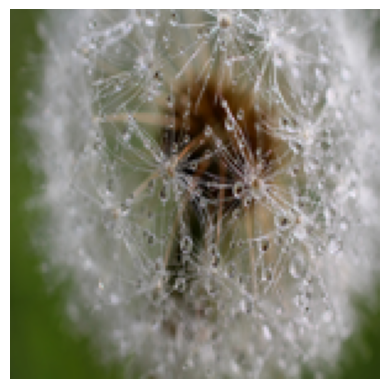

In [19]:
# Display sample image
img_tensor = np.array(pics_arr[2], dtype='int')
plt.imshow(img_tensor)
plt.axis('off')
plt.show()

Before we input the image to the CNN, we have to add the batch dimension using ```np.expand_dims```


In [20]:
img_tensor.shape

(150, 150, 3)

In [21]:
img_tensor = np.expand_dims(img_tensor, axis=0) # axis = (0, 1, 2, 3,...)
img_tensor.shape

(1, 150, 150, 3)

In [22]:
y = classifier.predict(img_tensor, verbose=0)
print(f"The predicted output of the sample image has a shape of {y.shape}.")

The predicted output of the sample image has a shape of (1, 9, 9, 32).


From the summary above we saw there are 7 layers in **classifier**. We can use the helper function **plot_activations_multilayer** to visualize the feature maps produced by each layer before training.


In [23]:
output_layers = [layer.output for layer in classifier.layers]
model_activation = Model(inputs=classifier.inputs, outputs=output_layers)
activations = model_activation.predict(img_tensor, verbose=0)
activations[0].shape

(1, 150, 150, 32)

In [24]:
plot_activations_multilayer(n_layers = 8,
                            img_per_row = 8,
                            classifier = classifier,
                            activations = activations)

Output hidden; open in https://colab.research.google.com to view.

Although the **classifier** model hasn't been trained, it is already evident that certain features are getting recognized in each separate layer. Now, let's proceed with building the model for classification.


#### Exercise: Add a Flattening layer


From the summary above, we see that the shape of

---

the output of the previous layer is $9\times9\times32$. Thus, the shape of the output of our flattening layer will be  $9\times9\times32 = 2592\times1$.


In [25]:
classifier.add(Flatten())
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2592)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,640 (190.00 KB)

 Trainable params: 48,640 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

<details><summary>Solution</summary>
    <code>classifier.add(Flatten()) </code></br>
</details>


#### Exercise: Add Dense Layers


Now the last step of building the **classifier** model is adding some fully-connected dense layers:

- Dense layer with 512 units and relu activation function.
- Dense layer with 5 units (because the dataset has 5 classes) and softmax activation function.


In [26]:
classifier.add(Dense(512, activation='relu'))
classifier.add(Dense(5, activation='softmax'))

<details><summary>Solution</summary>
    <code>classifier.add(Dense(units = 512, activation = 'relu'))</code></br>
    <code>classifier.add(Dense(units = 5, activation = 'softmax'))</code></br>
</details>


In [27]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,327,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,821 (5.26 MB)

 Trainable params: 1,378,821 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

### Prediction!

We compile the model using the Adam optimizer, categorical cross entropy as the loss function, and measuring performance based on its accuracy.


In [28]:
classifier.compile(optimizer = 'adam',
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

Let's fit the classifier on the train set and evaluate its performance against the validation set

**Note: This may take some time, go make yourself a coffee while waiting!**


In [29]:
classifier.fit(x = train_set,
               validation_data = val_set,
               epochs = epochs)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.2966 - loss: 1.5213 - val_accuracy: 0.4295 - val_loss: 1.2447
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5159 - loss: 1.1544 - val_accuracy: 0.5718 - val_loss: 1.1286
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.6026 - loss: 1.0375 - val_accuracy: 0.6170 - val_loss: 1.0078
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.6315 - loss: 0.9191 - val_accuracy: 0.5787 - val_loss: 1.0331
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.6435 - loss: 0.9205 - val_accuracy: 0.6361 - val_loss: 0.9493
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.6785 - loss: 0.8326 - val_accuracy: 0.6512 - val_loss: 0.8889
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.6801 - loss: 0.7949 - val_accuracy: 0.6594 - val_loss: 0.8594
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.6912 - loss: 0.7737 - val_accuracy: 0.6758 - v

Now that the network is trained and the kernels (the weight matrices of the layers) are learnt, we can visualize the kernels. For each Conv2d layer in the list of `classifier.layers`, it consists of multiple kernels (filters). To match the depth of the input to a Conv2d layer, each kernel's depth will have the same value as the input depth. The kernel depth is also referred to as the number of channels of a kernel.

For example, if the input to the first Conv2d layer is a 3-channel RGB image, then each kernel of the layer will consist of three channels (depth 3) where each channel can be visualized as a 2D grayscale image. Depending on how many different feature maps we want a Conv2d layer to learn, we specify the number of kernels (filters) in a layer.

With this idea in mind, let's look at how many kernels are learnt by our classifier:


In [33]:
for layer in classifier.layers:
    if 'conv2d' in layer.name:
        kernels, biases = layer.get_weights()
        print(f"layer name: {layer.name}, no. of kernels: {kernels.shape[-1]},"
        f" kernel shape: {kernels.shape[:2]}, kernel depth: {kernels.shape[2]}")

layer name: conv2d, no. of kernels: 32, kernel shape: (5, 5), kernel depth: 3
layer name: conv2d_1, no. of kernels: 64, kernel shape: (3, 3), kernel depth: 32
layer name: conv2d_2, no. of kernels: 32, kernel shape: (3, 3), kernel depth: 64
layer name: conv2d_3, no. of kernels: 32, kernel shape: (3, 3), kernel depth: 32


You can see that except for the first Conv2d layer, others all have depth of 32 or 64, which means to visualize each kernel we would need to plot out 32 or 64 channels of it! To not bombard you with hundreads and thousands of kernel images, we will just visualize 3 channels of 4 kernels from each Conv2d layer:


kernel shape of conv2d    : (5, 5, 3, 32)
kernel shape of conv2d_1  : (3, 3, 32, 64)
kernel shape of conv2d_2  : (3, 3, 64, 32)
kernel shape of conv2d_3  : (3, 3, 32, 32)


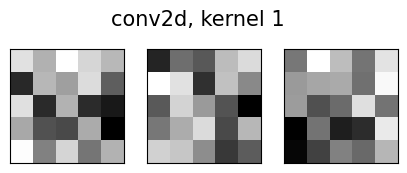

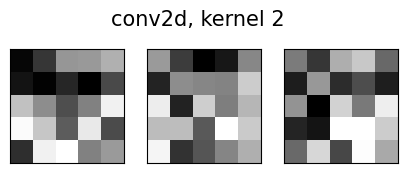

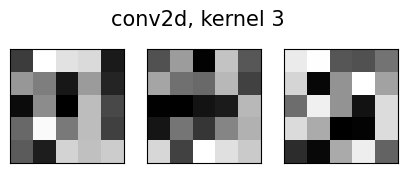

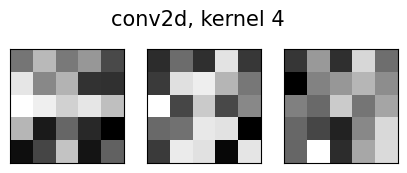

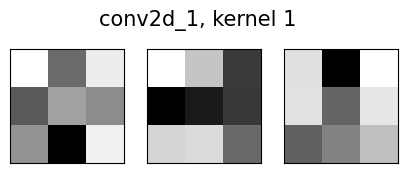

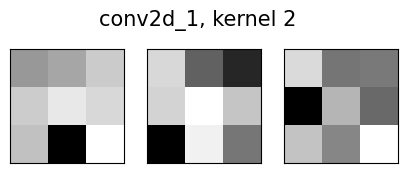

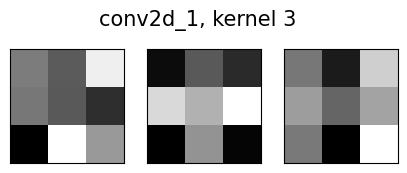

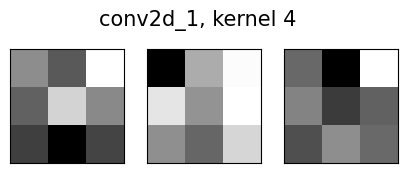

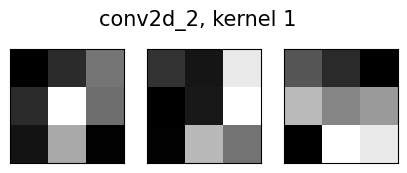

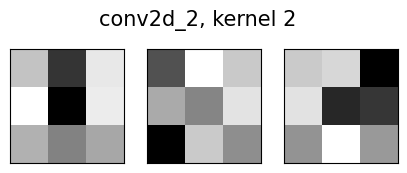

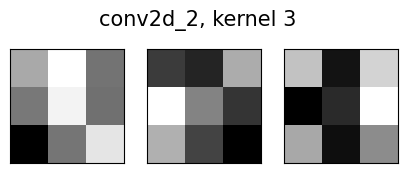

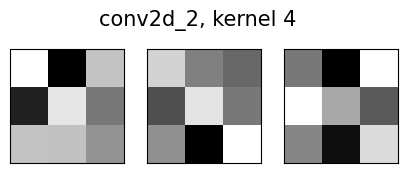

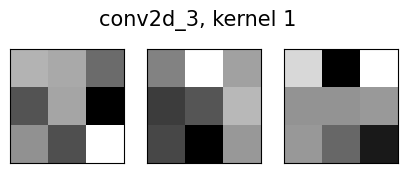

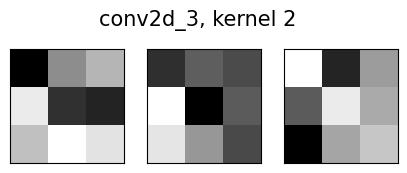

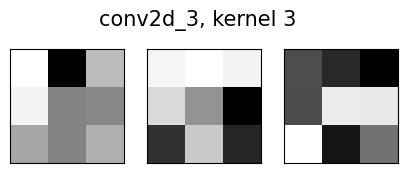

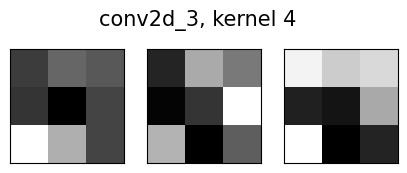

In [44]:
for layer in classifier.layers:
    if 'conv2d' in layer.name:
        name = layer.name
        kernels, _ = layer.get_weights()
        kmin, kmax = kernels.min(), kernels.max()
        kernels = (kernels - kmin) / (kmax - kmin) # min-max normalization
        print(f"kernel shape of {name:10}: {kernels.shape}")

        for i in range(4):
            kernel = kernels[:,:,:,i]
            fig = plt.figure(figsize=(5,2))
            fig.suptitle(f"{name}, kernel {i+1}", fontsize=15)

            for j in range(3):
                plt.subplot(1, 3, j+1)
                plt.imshow(kernel[:,:,j], cmap='gray')
                plt.xticks([])
                plt.yticks([])


The dark squares indicate small or inhibitory weights of the kernel and the light squares represent large or excitatory weights of the kernel. Using this intuition, we can see that, a kernel (filter) like the following detects a gradient from light in the top left to dark in the bottom right.


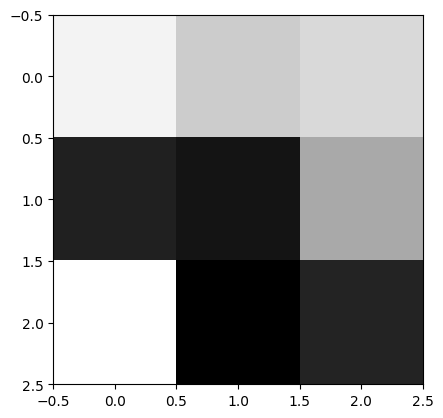

In [45]:
plt.imshow(kernels[:,:,2,3], cmap='gray')

After seeing the kernels used for convolution, let's take a look again at what the feature maps produced by the trained, intermediate layers look like:


In [47]:
layer_outputs = [layer.output for layer in classifier.layers]
activation_model = Model(inputs=classifier.inputs, outputs=layer_outputs)

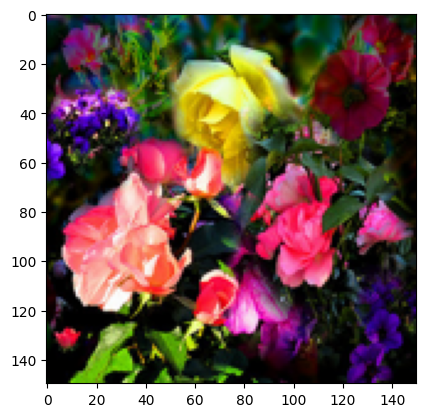

In [48]:
# let's pick a sample image
img_tensor = pics_arr[1]
plt.imshow(np.array(img_tensor, dtype='int'))

In [49]:
img_tensor = np.expand_dims(img_tensor, axis=0)
activations = activation_model.predict(img_tensor, verbose=0)[:6]
plot_activations_multilayer(7, 8, classifier, activations)

Output hidden; open in https://colab.research.google.com to view.

Compared to before, it's clear that after fitting the model on the train set, each consecutive layer is able to learn some abstract features. Let's predict the label for the sample image **img_tensor**.


In [52]:
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

Text(0.5, 1.0, 'Predicted class is: tulips')

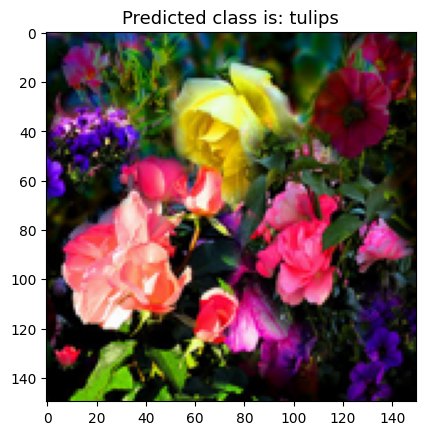

In [53]:
y = classifier.predict(img_tensor, verbose=0)
label = class_names[np.argmax(y)]

plt.imshow(img_tensor.reshape((img_w, img_h, 3)).astype("uint8"))
plt.title(f"Predicted class is: {label}", fontsize=13)

## Authors


[Richard Ye](https://linkedin.com/in/richard-ye?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) is a undergrad at the University of Toronto studying Statistics and Finance.



[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) is a Data Scientist at IBM Skills Network.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By  | Change Description |
| ----------------- | ------- | ----------- | ------------------ |
| 2022-07-05       | 0.1     | Richard Ye  | Created First Draft|
| 2022-07-07        | 0.1     | Roxanne Li  | Created Lab       |


Copyright © 2022 IBM Corporation. All rights reserved.
